In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
import random


In [ ]:
#optimizer class
class Optimizer:

    def __init__(self, learning_rate=0.01, epsilon=1e-4, beta=0.9, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2

    def sgd(self, parameters, grads, prev_u=None):

        for t in parameters.keys():
            parameters[t] -= self.learning_rate * grads[t]
        return parameters, prev_u

    def momentum_gradient_descent(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {key: np.zeros_like(value) for key, value in parameters.items()}         # Initialize with zeros (u(-1)= 0)
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + grads[t]
            parameters[t] -= self.learning_rate * prev_u[t]                                   #prev_u[t] accumuklates the history vector
        return parameters, prev_u

    def nesterov_accelerated_gradient_descent(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {t: np.zeros_like(value) for t, value in parameters.items()}             # initialize u(-1)= 0
        lookahead_params = {t: parameters[t] - beta * prev_u[t] for t in parameters.keys()}
        temp_grads = grads
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + self.learning_rate * temp_grads[t]                     #prev_u[t] accumuklates the history vector
            parameters[t] -= prev_u[t]
        return parameters, prev_u

    def rmsprop(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {t: np.zeros_like(value) for t, value in parameters.items()}
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + (1 - beta) * grads[t] ** 2
            parameters[t] -= (self.learning_rate / (np.sqrt(prev_u[t]) + self.epsilon)) * grads[t]
        return parameters, prev_u

    def adam(self, parameters, grads, prev_u=None):

        if prev_u is None or "step" not in prev_u:                                  #initialization
            prev_u = {"m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0}
        prev_u["step"] += 1
        step = prev_u["step"]
        for t in parameters.keys():
            prev_u["m"][t] = self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]         #bias corrected moment estimate
            prev_u["v"][t] = self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)
            m_hat = prev_u["m"][t] / (1 - self.beta1 ** step)
            v_hat = prev_u["v"][t] / (1 - self.beta2 ** step)
            parameters[t] -= (self.learning_rate * m_hat) / (np.sqrt(v_hat) + self.epsilon)     #update rule
        return parameters, prev_u

    def nadam(self, parameters, grads, prev_u=None):

        if prev_u is None or "step" not in prev_u:
            prev_u = {"m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0}
        prev_u["step"] += 1
        step = prev_u["step"]
        for t in parameters.keys():
            prev_u["m"][t] = self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]          #bias corrected moment estimate
            prev_u["v"][t] = self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)
            m_hat = prev_u["m"][t] / (1 - self.beta1 ** step)
            v_hat = prev_u["v"][t] / (1 - self.beta2 ** step)
            nadam_update = (self.beta1 * m_hat +
                            (1 - self.beta1) * grads[t] / (1 - self.beta1 ** step))
            parameters[t] -= (self.learning_rate / (np.sqrt(v_hat) + self.epsilon)) * nadam_update    #update rule
        return parameters, prev_u


In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes, weight_init="random", activation="sigmoid",
                 beta=0.9, beta1=0.9, beta2=0.999, weight_decay=0.0, loss_type='cross_entropy'):
        self.layer_sizes = layer_sizes
        self.weight_init = weight_init
        self.activation = activation
        self.weight_decay = weight_decay
        self.parameters = self.initialize_weights_bias(layer_sizes)
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.loss_type = loss_type

    # Activation functions
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def initialize_weights_bias(self, layer_size):
        parameters = {}
        L = len(layer_size) - 1
        for i in range(1, L + 1):
            if self.weight_init == "xavier":
                parameters[f"W{i}"] = (np.random.randn(layer_size[i], layer_size[i-1]) *
                                        np.sqrt(2 / (layer_size[i] + layer_size[i-1])))
            else:
                parameters[f"W{i}"] = np.random.randn(layer_size[i], layer_size[i-1])
            parameters[f"b{i}"] = np.zeros((layer_size[i], 1))
        return parameters

    def one_hot_encode(self, y, num_classes):
        y = y.astype(int).flatten()
        one_hot = np.zeros((y.shape[0], num_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

    def load_and_preprocess_data(self):
        # Modified: Load MNIST data instead of Fashion MNIST
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
        x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

        print("=" * 40)
        print("MNIST Dataset Details")  # Updated message
        print("=" * 40)
        print(f"Training Samples: {x_train.shape[0]}")
        print(f"Test Samples: {x_test.shape[0]}")
        print(f"Input Features: {x_train.shape[1]}")
        print("=" * 40)

        return (x_train, y_train), (x_test, y_test)

    def split_data(self):
        (x_train, y_train_raw), (x_test, y_test_raw) = self.load_and_preprocess_data()
        x_train, x_val, y_train_raw, y_val_raw = train_test_split(x_train, y_train_raw, test_size=0.1, random_state=42)
        num_classes = len(np.unique(y_train_raw))
        self.num_classes = num_classes
        y_train_enc = self.one_hot_encode(y_train_raw, num_classes)
        y_val_enc = self.one_hot_encode(y_val_raw, num_classes)
        y_test_enc = self.one_hot_encode(y_test_raw, num_classes)
        print("=" * 40)
        print("Updated MNIST Dataset Details")
        print("=" * 40)
        print(f"Training Samples: {x_train.shape[0]}")
        print(f"Validation Samples: {x_val.shape[0]}")
        print(f"Test Samples: {x_test.shape[0]}")
        return x_train, y_train_raw, y_train_enc, x_val, y_val_raw, y_val_enc, x_test, y_test_raw, y_test_enc

    def forward_propagation(self, x_batch, y_batch_raw, num_of_hidden_layers, num_neurons):
        pre_activations = {}
        activations = {"h0": x_batch.T}
        for i in range(1, num_of_hidden_layers + 1):
            a_i = np.dot(self.parameters[f"W{i}"], activations[f"h{i-1}"]) + self.parameters[f"b{i}"]
            if self.activation == "sigmoid":
                h_i = self.sigmoid(a_i)
            elif self.activation == "relu":
                h_i = self.relu(a_i)
            elif self.activation == "tanh":
                h_i = self.tanh(a_i)
            else:
                raise ValueError("activation function not defined")
            pre_activations[f"a{i}"] = a_i
            activations[f"h{i}"] = h_i

        L = num_of_hidden_layers + 1
        a_L = np.dot(self.parameters[f"W{L}"], activations[f"h{L-1}"]) + self.parameters[f"b{L}"]
        h_L = self.softmax(a_L)
        pre_activations[f"a{L}"] = a_L
        activations[f"h{L}"] = h_L
        return h_L.T, pre_activations, activations

    def backpropagation(self, x_batch, y_batch_enc, pre_activations, activations, optimizer, batch_size, prev_v, weight_decay):
        grads = {}
        L = len(self.layer_sizes) - 1
        nabla_a_L = activations[f"h{L}"].T - y_batch_enc
        grads[f"W{L}"] = (np.dot(nabla_a_L.T, activations[f"h{L-1}"].T)
                          + weight_decay * self.parameters[f"W{L}"]) / batch_size
        grads[f"b{L}"] = np.sum(nabla_a_L, axis=0, keepdims=True).T / batch_size

        for k in range(L-1, 0, -1):
            nabla_h_k = np.dot(self.parameters[f"W{k+1}"].T, nabla_a_L.T)
            if self.activation == "sigmoid":
                nabla_a_k = nabla_h_k * self.sigmoid_derivative(pre_activations[f"a{k}"])
            elif self.activation == 'relu':
                nabla_a_k = nabla_h_k * self.relu_derivative(pre_activations[f"a{k}"])
            elif self.activation == "tanh":
                nabla_a_k = nabla_h_k * self.tanh_derivative(pre_activations[f"a{k}"])
            else:
                raise ValueError("Activation not defined.")
            grads[f"W{k}"] = (np.dot(nabla_a_k, activations[f"h{k-1}"].T)
                              + weight_decay * self.parameters[f"W{k}"]) / batch_size
            grads[f"b{k}"] = np.sum(nabla_a_k, axis=1, keepdims=True) / batch_size
            nabla_a_L = nabla_a_k.T

        if isinstance(optimizer, Optimizer):
            raise ValueError("Should be an optimizer method (sgd, adam, etc.)")
        self.parameters, prev_v = optimizer(self.parameters, grads, prev_v)
        return self.parameters, prev_v

    def compute_loss(self, y_true, y_pred, batch_size, weight_decay):
        epsilon = 1e-8
        l2_norm = sum(np.sum(np.square(self.parameters[f"W{i}"])) for i in range(1, len(self.layer_sizes)))
        cross_entropy = -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
        mse = np.mean(np.square(y_true - y_pred))
        if self.loss_type == 'cross_entropy':
            return cross_entropy + 0.5 * weight_decay * l2_norm
        elif self.loss_type == 'mse':
            return mse + 0.5 * weight_decay * l2_norm
        else:
            raise ValueError("Loss type not defined")

    def plot_loss_chart(self, epochs, train_loss, val_loss):
        plt.figure(figsize=(4, 3))
        plt.plot(epochs, train_loss, marker='o', label="Training Loss")
        plt.plot(epochs, val_loss, marker='o', label="Validation Loss")
        plt.title("Loss vs. Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        return plt.gcf()

    def train_model(self, x_train, y_train_raw, y_train_enc, x_val, y_val_raw, y_val_enc,
                    num_hidden_layers, num_neurons, optimizer_type, learning_rate, num_epochs, batch_size, weight_decay):
        self.layer_sizes = [x_train.shape[1]] + [num_neurons]*num_hidden_layers + [self.num_classes]
        self.parameters = self.initialize_weights_bias(self.layer_sizes)
        opt = Optimizer(learning_rate=learning_rate, beta=self.beta, beta1=self.beta1, beta2=self.beta2)
        if optimizer_type == 'sgd':
            optimizer_function = opt.sgd
        elif optimizer_type == 'momentum':
            optimizer_function = opt.momentum_gradient_descent
        elif optimizer_type == 'nesterov':
            optimizer_function = opt.nesterov_accelerated_gradient_descent
        elif optimizer_type == 'rmsprop':
            optimizer_function = opt.rmsprop
        elif optimizer_type == 'adam':
            optimizer_function = opt.adam
        elif optimizer_type == 'nadam':
            optimizer_function = opt.nadam
        else:
            raise ValueError(f"optimizer not defined: {optimizer_type}")
        prev_u = None
        train_losses = []
        val_losses = []
        n_samples = x_train.shape[0]
        for epoch in range(1, num_epochs+1):
            epoch_loss = 0.0
            for i in range(0, n_samples, batch_size):
                batch_x = x_train[i:i+batch_size, :]
                batch_enc = y_train_enc[i:i+batch_size, :]
                y_hat, pre_acts, acts = self.forward_propagation(batch_x, None, num_hidden_layers, num_neurons)
                self.parameters, prev_u = self.backpropagation(batch_x, batch_enc, pre_acts, acts,
                                                               optimizer_function, batch_x.shape[0], prev_u, weight_decay)
                epoch_loss += self.compute_loss(batch_enc, y_hat, batch_x.shape[0], weight_decay)
            avg_train_loss = epoch_loss / (n_samples / batch_size)
            train_losses.append(avg_train_loss)
            y_hat_val, _, _ = self.forward_propagation(x_val, None, num_hidden_layers, num_neurons)
            val_loss = self.compute_loss(y_val_enc, y_hat_val, x_val.shape[0], weight_decay)
            val_losses.append(val_loss)
            y_hat_full, _, _ = self.forward_propagation(x_train, None, num_hidden_layers, num_neurons)
            train_acc = np.mean(np.argmax(y_hat_full, axis=1) == y_train_raw)
            val_acc = np.mean(np.argmax(y_hat_val, axis=1) == y_val_raw)
            print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={val_loss:.4f}, "
                  f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
        epochs_range = list(range(1, num_epochs + 1))
        fig = self.plot_loss_chart(epochs_range, train_losses, val_losses)
        plt.show()
        return self.parameters, train_losses, val_losses

    def test_model(self, x_test, y_test_raw, y_test_enc, num_hidden_layers, num_neurons, batch_size):
        y_hat, _, _ = self.forward_propagation(x_test, None, num_hidden_layers, num_neurons)
        test_loss = self.compute_loss(y_test_enc, y_hat, x_test.shape[0], self.weight_decay)
        y_hat_labels = np.argmax(y_hat, axis=1)
        test_accuracy = np.mean(y_hat_labels == y_test_raw)
        print(f"Test Loss: {test_loss:.4f} \tTest Accuracy: {test_accuracy:.4f}")
        return test_loss, test_accuracy


MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
Updated MNIST Dataset Details
Training Samples: 54000
Validation Samples: 6000
Test Samples: 10000
Training model with cross-entropy loss
Epoch 1: train_loss=0.7101, val_loss=0.3526, train_acc=0.9028, val_acc=0.9010
Epoch 2: train_loss=0.3056, val_loss=0.2664, train_acc=0.9240, val_acc=0.9202
Epoch 3: train_loss=0.2461, val_loss=0.2265, train_acc=0.9358, val_acc=0.9315
Epoch 4: train_loss=0.2101, val_loss=0.1983, train_acc=0.9447, val_acc=0.9408
Epoch 5: train_loss=0.1828, val_loss=0.1764, train_acc=0.9519, val_acc=0.9488
Epoch 6: train_loss=0.1611, val_loss=0.1594, train_acc=0.9570, val_acc=0.9532
Epoch 7: train_loss=0.1434, val_loss=0.1458, train_acc=0.9615, val_acc=0.9562
Epoch 8: train_loss=0.1286, val_loss=0.1348, train_acc=0.9650, val_acc=0.9587
Epoch 9: train_loss=0.1160, val_loss=0.1254, train_acc=0.9684, val

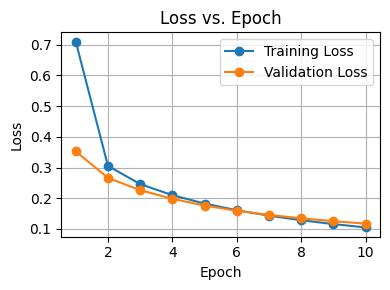

Test Loss: 0.1196 	Test Accuracy: 0.9636
Final Training Loss: 0.10503759279366012
Final Validation Loss: 0.11741216456625789
Test Loss: 0.11956898393581569
Test Accuracy: 0.9636


In [ ]:
epochs = 10      #1st configuration
num_hidden_layers = 5
num_neurons = 128
learning_rate = 1e-4
activation = 'tanh'
optimizer = 'adam'
batch_size = 128
weight_init = 'xavier'
l2_reg = 0
loss_type = 'cross_entropy'

input_dim = 28 * 28
layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers
nn = NeuralNetwork(
    layer_sizes=layer_sizes,
    weight_init=weight_init,
    activation=activation,
    weight_decay=l2_reg,
    loss_type=loss_type
)

# Load and Preprocess data
(x_train, y_train), (x_test, y_test) = nn.load_and_preprocess_data()

# Split data
X_train, Y_train_raw, Y_train_enc, X_val, Y_val_raw, Y_val_enc, X_test, Y_test_raw, Y_test_enc = nn.split_data()

print("Training model with cross-entropy loss")

# Training
params, train_losses, val_losses = nn.train_model(
    x_train=X_train,
    y_train_raw=Y_train_raw,
    y_train_enc=Y_train_enc,
    x_val=X_val,
    y_val_raw=Y_val_raw,
    y_val_enc=Y_val_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    optimizer_type=optimizer,
    learning_rate=learning_rate,
    num_epochs=epochs,
    batch_size=batch_size,
    weight_decay=l2_reg
)

# Testing
test_loss, test_accuracy = nn.test_model(
    x_test=X_test,
    y_test_raw=Y_test_raw,
    y_test_enc=Y_test_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    batch_size=batch_size
)

print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
Updated MNIST Dataset Details
Training Samples: 54000
Validation Samples: 6000
Test Samples: 10000
Training model with cross-entropy loss
Epoch 1: train_loss=0.8423, val_loss=0.4602, train_acc=0.9231, val_acc=0.9242
Epoch 2: train_loss=0.4276, val_loss=0.3884, train_acc=0.9443, val_acc=0.9430
Epoch 3: train_loss=0.3732, val_loss=0.3532, train_acc=0.9566, val_acc=0.9527
Epoch 4: train_loss=0.3436, val_loss=0.3320, train_acc=0.9645, val_acc=0.9610
Epoch 5: train_loss=0.3237, val_loss=0.3187, train_acc=0.9697, val_acc=0.9640
Epoch 6: train_loss=0.3089, val_loss=0.3098, train_acc=0.9742, val_acc=0.9673
Epoch 7: train_loss=0.2972, val_loss=0.3034, train_acc=0.9771, val_acc=0.9698
Epoch 8: train_loss=0.2877, val_loss=0.2996, train_acc=0.9796, val_acc=0.9708
Epoch 9: train_loss=0.2798, val_loss=0.2968, train_acc=0.9816, val

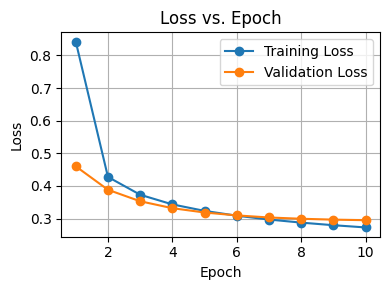

Test Loss: 0.3026 	Test Accuracy: 0.9715
Final Training Loss: 0.2729567396452842
Final Validation Loss: 0.2951442835983161
Test Loss: 0.3025848015280534
Test Accuracy: 0.9715


In [ ]:
epochs = 10   #2nd configuration
num_hidden_layers = 5
num_neurons = 128
learning_rate = 1e-4
activation = 'relu'
optimizer = 'adam'
batch_size = 64
weight_init = 'xavier'
l2_reg = 0.0005
loss_type = 'cross_entropy'

input_dim = 28 * 28
layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers
nn = NeuralNetwork(
    layer_sizes=layer_sizes,
    weight_init=weight_init,
    activation=activation,
    weight_decay=l2_reg,
    loss_type=loss_type
)

# Load and Preprocess data
(x_train, y_train), (x_test, y_test) = nn.load_and_preprocess_data()

# Split data
X_train, Y_train_raw, Y_train_enc, X_val, Y_val_raw, Y_val_enc, X_test, Y_test_raw, Y_test_enc = nn.split_data()

print("Training model with cross-entropy loss")

# Training
params, train_losses, val_losses = nn.train_model(
    x_train=X_train,
    y_train_raw=Y_train_raw,
    y_train_enc=Y_train_enc,
    x_val=X_val,
    y_val_raw=Y_val_raw,
    y_val_enc=Y_val_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    optimizer_type=optimizer,
    learning_rate=learning_rate,
    num_epochs=epochs,
    batch_size=batch_size,
    weight_decay=l2_reg
)

# Testing
test_loss, test_accuracy = nn.test_model(
    x_test=X_test,
    y_test_raw=Y_test_raw,
    y_test_enc=Y_test_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    batch_size=batch_size
)

print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
Updated MNIST Dataset Details
Training Samples: 54000
Validation Samples: 6000
Test Samples: 10000
Training model with cross-entropy loss
Epoch 1: train_loss=0.7342, val_loss=0.4647, train_acc=0.9141, val_acc=0.9155
Epoch 2: train_loss=0.4386, val_loss=0.4038, train_acc=0.9318, val_acc=0.9295
Epoch 3: train_loss=0.3920, val_loss=0.3699, train_acc=0.9440, val_acc=0.9407
Epoch 4: train_loss=0.3603, val_loss=0.3454, train_acc=0.9516, val_acc=0.9482
Epoch 5: train_loss=0.3366, val_loss=0.3282, train_acc=0.9575, val_acc=0.9543
Epoch 6: train_loss=0.3189, val_loss=0.3165, train_acc=0.9625, val_acc=0.9583
Epoch 7: train_loss=0.3052, val_loss=0.3082, train_acc=0.9667, val_acc=0.9612
Epoch 8: train_loss=0.2943, val_loss=0.3019, train_acc=0.9703, val_acc=0.9633
Epoch 9: train_loss=0.2853, val_loss=0.2970, train_acc=0.9735, val

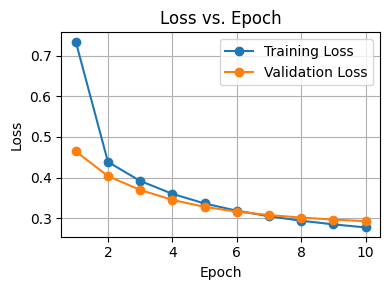

Test Loss: 0.2975 	Test Accuracy: 0.9663
Final Training Loss: 0.2777377401882421
Final Validation Loss: 0.2931423339849304
Test Loss: 0.2974623760042763
Test Accuracy: 0.9663


In [ ]:
epochs = 10   #3rd configuration
num_hidden_layers = 4
num_neurons = 128
learning_rate = 1e-4
activation = 'tanh'
optimizer = 'adam'
batch_size = 64
weight_init = 'xavier'
l2_reg = 0.0005
loss_type = 'cross_entropy'

input_dim = 28 * 28
layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers
nn = NeuralNetwork(
    layer_sizes=layer_sizes,
    weight_init=weight_init,
    activation=activation,
    weight_decay=l2_reg,
    loss_type=loss_type
)

# Load and Preprocess data
(x_train, y_train), (x_test, y_test) = nn.load_and_preprocess_data()

# Split data
X_train, Y_train_raw, Y_train_enc, X_val, Y_val_raw, Y_val_enc, X_test, Y_test_raw, Y_test_enc = nn.split_data()

print("Training model with cross-entropy loss")

# Training
params, train_losses, val_losses = nn.train_model(
    x_train=X_train,
    y_train_raw=Y_train_raw,
    y_train_enc=Y_train_enc,
    x_val=X_val,
    y_val_raw=Y_val_raw,
    y_val_enc=Y_val_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    optimizer_type=optimizer,
    learning_rate=learning_rate,
    num_epochs=epochs,
    batch_size=batch_size,
    weight_decay=l2_reg
)

# Testing
test_loss, test_accuracy = nn.test_model(
    x_test=X_test,
    y_test_raw=Y_test_raw,
    y_test_enc=Y_test_enc,
    num_hidden_layers=num_hidden_layers,
    num_neurons=num_neurons,
    batch_size=batch_size
)

print("Final Training Loss:", train_losses[-1])
print("Final Validation Loss:", val_losses[-1])
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)